# ADA Assignment 2
Marc Schmid, student number 13349752

Jorge Villanueva Salamero, student number 13350309

No. 31005

## Structure of the Notebook

1. Code with inline commentation and explanations
2. Documentation
3. Link to the video

## 1. Code

As the original data consisted of a great number attributes, and most of them were irrelevant for our problem solution approach. It was necessary to preposcces the data to extract only the star rating of the users to the restaurants.

We let the possibility of looking at the original data by running the following command. 

The dataset contains reviews of users towards restaurants; the parameters are review ID, user id, business id, stars, date, text, useful, funny and cool.

We gave the business and the users numerical values, which are represented by the rows and columns of our matrix. The star rating of the business is represented by the value in the specific column and rows of our matrix. For example, if user 100 rates restaurant 300 with 5 stars, the matrix $M[100,300]$ has the value 5. 

The data is then stored in sparse matrixes, which just store the indices and the values which are non-zero or in our case available.

In [1]:
import json

with open('yelp_academic_dataset_review.json') as f:
    for line in f:
        print(line)



{"review_id":"x7mDIiDB3jEiPGPHOmDzyw","user_id":"msQe1u7Z_XuqjGoqhB0J5g","business_id":"iCQpiavjjPzJ5_3gPD5Ebg","stars":2,"date":"2011-02-25","text":"The pizza was okay. Not the best I've had. I prefer Biaggio's on Flamingo \/ Fort Apache. The chef there can make a MUCH better NY style pizza. The pizzeria @ Cosmo was over priced for the quality and lack of personality in the food. Biaggio's is a much better pick if youre going for italian - family owned, home made recipes, people that actually CARE if you like their food. You dont get that at a pizzeria in a casino. I dont care what you say...","useful":0,"funny":0,"cool":0}

{"review_id":"dDl8zu1vWPdKGihJrwQbpw","user_id":"msQe1u7Z_XuqjGoqhB0J5g","business_id":"pomGBqfbxcqPv14c3XH-ZQ","stars":5,"date":"2012-11-13","text":"I love this place! My fiance And I go here atleast once a week. The portions are huge! Food is amazing. I love their carne asada. They have great lunch specials... Leticia is super nice and cares about what you think

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{"review_id":"9j7MIVfaO3uWX8Zo_nyU1w","user_id":"xvMaBf31ILwEuwXIMBTVLw","business_id":"68O06rHoYy-7IH04I2OEXg","stars":2,"date":"2012-10-15","text":"The food was extremely average or slightly below.  Our pizza was fairly bland.  Nothing special at all.  Instead of regular pepperoni or small balls of sausage, we got  actual  paper thin FLAKES of them.  Even these flakes had little meat flavor  Won't be back and wouldn't recommend.","useful":0,"funny":0,"cool":0}

{"review_id":"T4j5Oa6SqSwkdmct68zfSA","user_id":"xvMaBf31ILwEuwXIMBTVLw","business_id":"iWjuG3ZfLGVTj7nTutGloQ","stars":1,"date":"2015-07-15","text":"Several weeks after purchasing a refrigerator it started running all the time and it was making a groaning noise.  The office repeatedly refused to help me in any way despite my supposed \"90 day guarantee.  Read all the other reviews and NEVER DO BUSINESS HERE!!!","useful":0,"funny":0,"cool":0}

{"review_id":"uhlKjdoq6bSYvTkJIv2caA","user_id":"whnTq0p21igcuYj6fJisxA","business_i

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 4694: character maps to <undefined>

The goal of this task is to recommend restaurants to users based on the rating data in the Yelp dataset. For this, we try to predict the rating a user will give to a restaurant they have not been to yet based on a latent factor model.
The yelp dataset can be downloaded by https://www.kaggle.com/yelp-dataset/yelp-dataset
For simplicity we reduced the dataset and stored it in a numpy file. It saves space and will be added to the code.

### Data Preprocessing 

- due to huge dataset of yelp, just used the recommendation values otherwise we would have needed a cluster to compute it
- kill small amount of reviews ( removed restaurants with less then 10 reviews)
- substract the mean of the values ( so shift the user means, as everybody rates slightly different) 
- split data in training, validation and test to prevent overfitting (and test the algorithm properly)

In [2]:
import scipy.sparse as sp
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge
import time
import copy
import pdb


## Structure of the Code

1. Loading the ratings into a Sparse matrix -> as a way to save a lot of memory and reduce the runtime of the model
2.Preprocessing of the Data:
    - shifting the user mean
    - deleting small amounts of ratings for all the restaurants
    -splitting the dataset into training, validation and test set
3. We implemented a latent factor model which is based on an alternating optimization algorithm. This is introduced right infront of the method
4. We analyzed the training process of the model
5. We implemented a latent factor model which is based on stochastic gradient descent to find the hidden parameters 
6. Analysis of the training process of the second model
7. Implementation of a Hyperparameter search to find the best parameters for the gradient descent model
8. Final comparison of the models and conclusions based on the problem solutions

Load the ratings from a self generated file (based on yelp) that is way smaller then the 3GB yelp dataset from kaggle)

In [3]:
ratings = np.load("ratings.npy")

In [4]:
num_users = np.max(ratings[:,0]) + 1
num_restaurants = np.max(ratings[:,1]) + 1

M = sp.lil_matrix((num_users, num_restaurants))
for row in ratings:
    M[row[0],row[1]] = row[2]
M = sp.csr_matrix(M)

To make the recommendation more stable we recursively remove restaurants with less then 10 ratings

In [5]:
def preprocessing(matrix, min_entries):
    '''
    input:
        matrix: shape [N,D] -> gets processed
        min_entries: int -> min number of nonzero entries per row&columns
    returns: 
        matrix: shape[N'<=N, D'<=D]
    '''
    
    print("Shape before: {}".format(matrix.shape))
    start = time.time()

    while True:
        N ,D = matrix.shape[0], matrix.shape[1]
        matrix = matrix[matrix.getnnz(axis=1) > min_entries][:, matrix.getnnz(axis=0) > min_entries]
        N_new ,D_new = matrix.shape[0], matrix.shape[1]
        converged = (N_new - N == 0 and D_new - D == 0)
        if converged:
            break
    
    end = time.time()
    
    nnz = matrix>0
    assert (nnz.sum(0).A1 > min_entries).all()
    assert (nnz.sum(1).A1 > min_entries).all()
    print("Shape after: {}".format(matrix.shape))
    
    return matrix

shift the user mean to make the data more stable

In [6]:
def shift_user_mean(matrix):
    '''
    input: 
        matrix [N,D]
    output: 
        matrix [N,D]->with shifted user means
        user_means [N]->to recover states
    
    '''
    mean = np.array(matrix.sum(axis=1))
    div = np.array(matrix.getnnz(axis=1))
    user_means = mean[:,0]/div
    
    #subtract mean from each row
    nonzero = matrix.nonzero()
    matrix = matrix.tolil()
    for i,j in zip(nonzero[0], nonzero[1]):
        matrix[i,j] -= user_means[i]
    matrix = matrix.tocsr()
    
    assert np.all(np.isclose(matrix.mean(1), 0))
    return matrix, user_means

split the data insto training validation and test set:
everything is vectorized, so that the c-api of python can apply the better running time


In [7]:
def split_data(matrix, n_validation, n_test):
    '''
    input: 
        matrix [N,D] 
        
        n_validation int
        
        n_test int
    
    return: 
        
        matrix_split [N,D]->test&val entries are 0 
        
        val_idx     -> indices of validation
        
        test_idx    -> indices of test
        
        val_values  -> values of validation indices
        
        test_values -> values of test indices
    
    '''
    #random seed is used to reproduse the results
    np.random.seed(4)
    
    # select validation data
    rand_val = np.random.choice(matrix.getnnz(), n_validation, replace=False)
    val_idx = (matrix.nonzero()[0][rand_val], matrix.nonzero()[1][rand_val])
    val_values = np.array(matrix[val_idx]).reshape(n_validation,)
    matrix_split = matrix.tolil()
    for i,j in zip(val_idx[0], val_idx[1]):
        matrix_split[i,j] = 0
    matrix_split = matrix_split.tocsr()
    
    # select test data
    rand_test = np.random.choice(matrix_split.getnnz(), n_test, replace=False)
    test_idx = (matrix_split.nonzero()[0][rand_test], matrix_split.nonzero()[1][rand_test])
    test_values = np.array(matrix_split[test_idx]).reshape(n_validation,)
    matrix_split = matrix_split.tolil()
    for i,j in zip(test_idx[0], test_idx[1]):
        matrix_split[i,j] = 0
    matrix_split = matrix_split.tocsr()
    
    
    matrix_split.eliminate_zeros()
    return matrix_split, val_idx, test_idx, val_values, test_values

In [8]:
M = preprocessing(M, 10)

Shape before: (337867, 5899)
Shape after: (11275, 3531)


In [9]:
n_validation = 200
n_test = 200
# Split data
M_train, val_idx, test_idx, val_values, test_values = split_data(M, n_validation, n_test)

In [10]:
# Store away the nonzero indices of M before subtracting the row means.
nonzero_indices = np.vstack((M_train.nonzero()[0], M_train.nonzero()[1])).T

# Remove user means.
M_shifted, user_means = shift_user_mean(M_train)

# Apply the same shift to the validation and test data.
val_values_shifted = val_values - user_means[val_idx[0]]
test_values_shifted = test_values - user_means[test_idx[0]]

## Alternating optimization with or without SVDs
The alternating optimization algorithm was acutally a substep in the winning code of the Netflix challenge recommender system.
The problem is that you have large sets of sparse data which is really challenging:
- similarity search is expensive because of high complexity of distance functions
- highly correlated dimensions could cause trouble for some algorithms
- we got the curse of dimensionality
- its pretty hard to visiualize high dimensional data.

With an SVD we can reduce the data to the correlating values ( data with high variance (big eigenvalues) and small variance ( low eigenvalues). The problem is that standard SVD is not working with sparse data, as for the rating system not many movies are rated.

SVDs are basically optimization algorithms which are based on power iteration or  subspace iteration methods. The SVD is defined as $A = U \Sigma V^T$ where A is the recommender matrix, $\Sigma $ are the eigenvalues and U and V are orthogonal matrices of eigenvectors. So if we use SVDs on unseen data we get The ratings via $R = Q P^T$ and $Q= U \Sigma$ and $P=V$. So if we do the SVDs with minimum reconstruction error, we force different complications like that the sum of the reconstruction error is over all entries (no-rating = zero-rating) and we have missing entries and R (where classical SVDs is not defined). So our goal is to find $Q \in \mathcal{R}^{n\times k }$ and $P \in \mathcal{R}^{d\times k }$ 
such that 
$$ \min_{P,Q} \sum_{i,x\in R} (r_{x,i}-q_xp_i^T)^2$$
Therefoe we use Alternating Optimization as an approach (Alternating optimization is a Standard method for latent factor models. I.e.:it also gets used to solve Gaussian mixture models, where we first update the distributions and then the latent variables):

The steps are : 
1. initialize $P,Q$ and $t=0$
2. $P^{t+1} = argmin_P f(P,Q^t)$
3. $Q^{t+1} = argmin_P f(P^{t+1},Q)$
4. $t=t+1$
5. goto 2 until values converge

Since P and Q are fixed respectively, the problem reduces to an ordinary least sqaure regression problem which has a closed form solution.
Drawbacks of alternating optimization is that the solution is only an approximation , there is no guarantee that the solution is close to the optimal solution and its highly dependant on initial data/initialziation -> therefore we made the initialization method, to see the difference between a random initialization, and a good approximation with a SVD-initialization.

In [11]:
def initialize_Q_P(matrix, k, init='random'):
    '''
    input: 
        matrix [N,D]
        k   int-> number of latent dim
        init state of initalization (random or by svds)
    
    returns: 
        Q [N,k] initial Q matrix of a latent factor model
        P [k,D] initial P matrix of a latent factor model
    
    '''
    N, D = matrix.shape[0], matrix.shape[1]
    if init == 'svd':
        
        Q, _, P = svds(matrix, k=k) 
    elif init == 'random':
        
        np.random.seed(6)
        Q = np.random.uniform(size=(N,k))
        P = np.random.uniform(size=(k,D))
    else:
        raise ValueError
        
    assert Q.shape == (matrix.shape[0], k)
    assert P.shape == (k, matrix.shape[1])
    return Q, P

We have to split training and validation loss function, as then we have a better running time, as well as less usage of memory.
$$\mathcal{L} = \sum (M-QP^T)^2$$

In [12]:
def loss_function(P,Q,M,non_zero_idx):
    '''
    the loss function is the root sqaure error RSE
    '''
    return np.sum(np.array(M[non_zero_idx[:,0], non_zero_idx[:,1]]-(Q.dot(P))[non_zero_idx[:,0], non_zero_idx[:,1]])**2)

In [13]:
def loss_validation(val_values, val_idx, P, Q):
    '''
    the loss function is the root sqaure error RSE
    '''
    return np.sum(np.array(val_values-(Q.dot(P))[val_idx[0], val_idx[1]])**2)

### Algorithm :
for P as well as for Q we have closed form solutions.
Therefore the ordinary least sqaured solution for each iteration becomes
the P-update is:
$$ p_i^T = \left(\frac{1}{|R_{*,i}|}\sum_{x \in R_{*,i}} q_x^Tq_x\right)^{-1} \frac{1}{|R_{*,i}|}\sum_{x \in R_{*,i}} q_x^T r_{xi} $$
The Q-update is:
$$ q_x^T = \left(\frac{1}{|R_{i,*}|}\sum_{x \in R_{i,*}} p_x^Tp_x \right)^{-1} \frac{1}{|R_{i,*}|}\sum_{x \in R_{i,*}} p_x^T r_{ix} $$
For computational reasons, we used the scipy least sqaured model, to fit the coefficients. Further more we replaced the sum by matrix multiplication, as python using c code for that and increases efficiency.

In [16]:
def latent_factor_alternating_optimization(M, non_zero_idx, k, val_idx, val_values,
                                           reg_lambda, max_steps=100, init='random',
                                           log_every=1, patience=10, eval_every=1):
    '''
    input
        M [N,D] -> matrix to factorize
        
        non_zero_idx -> indices of non zero entries
        
        k -> latent dimensions
        
        Val_idx -> validation indices
        
        val_values -> validation values
        
        reg_lambda -> regularization strength
        
    returns
        best_Q -> best Q based on val loss
        
        best_P -> best P based on val loss
        
        validation_losses -> to plot loss over time
        
        train_losses -> to plot loss over time
        
        converged_after -> convergence point



    '''
    Q,P = initialize_Q_P(M, k, init=init)  
    converged_after = -1
    train_losses, validation_losses, time_per_iteration = [], [], []
    best_Q, best_P = Q, P
    best_val = loss_validation(val_values, val_idx, P, Q)
    if reg_lambda > 0:  
        model = Ridge(alpha=reg_lambda)#, solver='lsqr')
    else:
        model = LinearRegression()
    
    # Update P and Q
    for iters in range(max_steps):
        start = time.time()
        # Update P
        for i in range(M.shape[1]):
            indices = non_zero_idx[non_zero_idx[:,1] == i][:,0]
            if indices.size > 0:
                y_train = M[indices, i].A.flatten()
                X_train = Q[indices]
                model.fit(X_train, y_train)
                P[:,i] = model.coef_
        # Update Q
        for x in range(M.shape[0]):
            indices = non_zero_idx[non_zero_idx[:,0] == x][:,1]
            if indices.size > 0:
                y_train = M[x, indices].A.flatten()
                X_train = P[:,indices].T
                model.fit(X_train, y_train)
                Q[x] = model.coef_
        #append loss for plotting
        train_losses.append(loss_function(P, Q, M, non_zero_idx))
        validation_losses.append(loss_validation(val_values, val_idx, P, Q))
        if iters > 1 and validation_losses[iters] < best_val and iters % eval_every == 0: 
            best_Q, best_P, best_val = Q, P, validation_losses[iters]
            converged_after = iters * eval_every
        else:
            patience -= 1
            
        end = time.time()
        time_per_iteration.append(end - start)
        print("Iteration %d,  training loss: %.3f, validation loss: %.3f"
              % (iters, train_losses[iters], validation_losses[iters]))
        if patience == 0: break
        if iters == max_steps - 1: converged_after = -1
        
    average_time = np.mean(np.array(time_per_iteration))
    if converged_after == -1:
        print("Did not converge in %d iterations, on average %.2f seconds per iteration." % (max_steps, average_time))
    else:
        print("Converged after %d iterations, on average %.2f seconds per iteration." % (converged_after, average_time))
    
    
    return best_Q, best_P, validation_losses, train_losses, converged_after

As the hyperparameter search is an exhaustive search and can take a lot of time, we tested the algorithm with one combination of values here.


We run the alternating optimization algorithm with $k=100$, $\lambda=1$ and a random initialization. We plot the training and validation losses over time.

In [17]:
Q_a, P_a, val_l_a, tr_l_a, conv_a = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                           k=100, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=1, init='svd',
                                                                           max_steps=100, patience=10)

Iteration 0,  training loss: 63974.220, validation loss: 488.204
Iteration 1,  training loss: 13211.078, validation loss: 376.392
Iteration 2,  training loss: 9582.094, validation loss: 344.571
Iteration 3,  training loss: 8130.341, validation loss: 333.175
Iteration 4,  training loss: 7346.789, validation loss: 328.963
Iteration 5,  training loss: 6865.832, validation loss: 328.015
Iteration 6,  training loss: 6547.955, validation loss: 328.719
Iteration 7,  training loss: 6326.541, validation loss: 330.219
Iteration 8,  training loss: 6165.615, validation loss: 332.064
Iteration 9,  training loss: 6044.564, validation loss: 334.009
Did not converge in 100 iterations, on average 23.02 seconds per iteration.


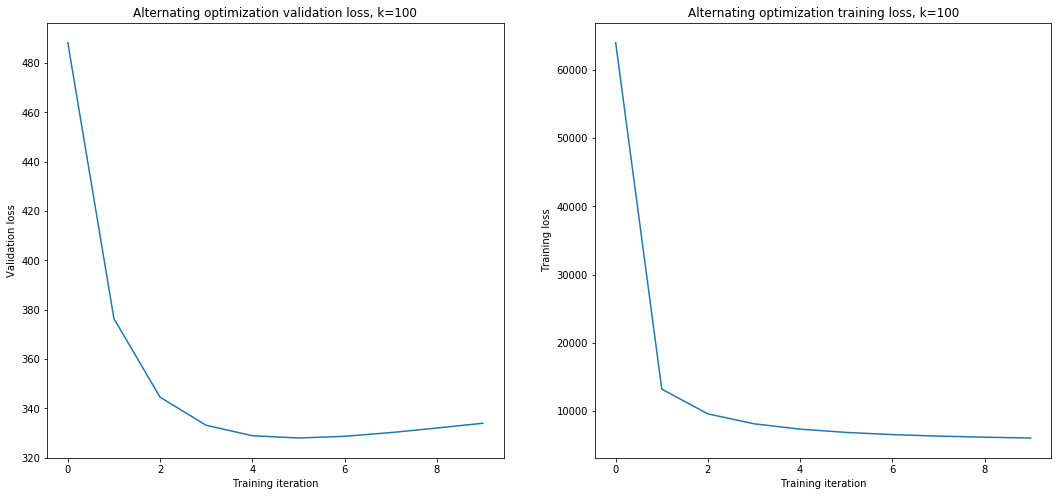

In [19]:
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
x = np.arange(0, len(val_l_a), 1)
plt.plot(x, val_l_a)
plt.title(s='Alternating optimization validation loss, k=100', loc='center')
plt.xlabel(s='Training iteration')
plt.ylabel(s='Validation loss')
plt.xticks(range(0,len(x), 2))

# second plot
plt.subplot(1, 2, 2)
plt.plot(x, tr_l_a)
plt.title(s='Alternating optimization training loss, k=100', loc='center')
plt.xlabel(s='Training iteration')
plt.ylabel(s='Training loss')
plt.xticks(range(0,len(x), 2))
plt.show()

In [20]:
Q_a, P_a, val_l_a, tr_l_a, conv_a = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                           k=100, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=1, init='random',
                                                                           max_steps=100, patience=10)

Iteration 0,  training loss: 32187.221, validation loss: 330.925
Iteration 1,  training loss: 11342.230, validation loss: 299.271
Iteration 2,  training loss: 8271.164, validation loss: 288.510
Iteration 3,  training loss: 7236.063, validation loss: 284.276
Iteration 4,  training loss: 6738.184, validation loss: 284.390
Iteration 5,  training loss: 6452.862, validation loss: 287.097
Iteration 6,  training loss: 6270.879, validation loss: 290.949
Iteration 7,  training loss: 6144.610, validation loss: 295.178
Iteration 8,  training loss: 6051.272, validation loss: 299.348
Iteration 9,  training loss: 5979.204, validation loss: 303.172
Iteration 10,  training loss: 5921.700, validation loss: 306.561
Iteration 11,  training loss: 5874.531, validation loss: 309.554
Converged after 3 iterations, on average 22.78 seconds per iteration.


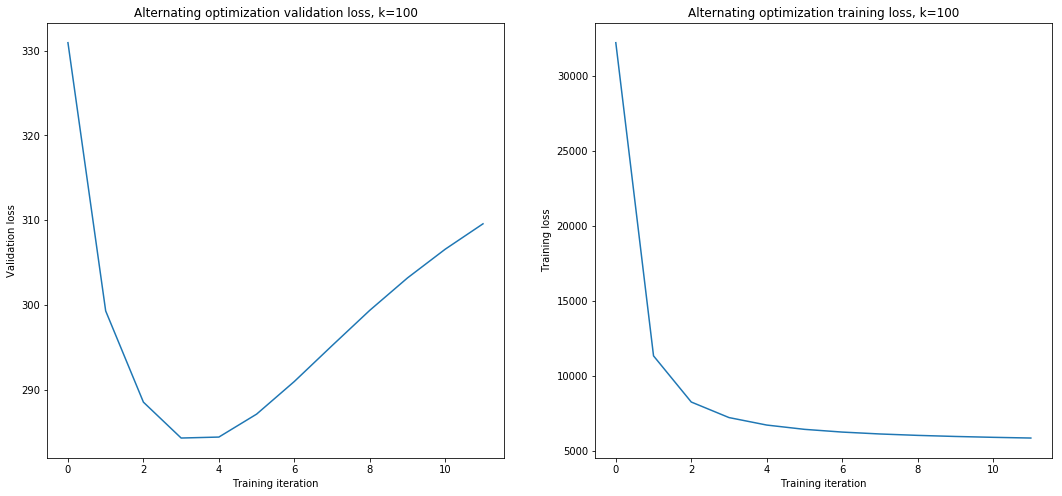

In [21]:
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
x = np.arange(0, len(val_l_a), 1)
plt.plot(x, val_l_a)
plt.title(s='Alternating optimization validation loss, k=100', loc='center')
plt.xlabel(s='Training iteration')
plt.ylabel(s='Validation loss')
plt.xticks(range(0,len(x), 2))

# second plot
plt.subplot(1, 2, 2)
plt.plot(x, tr_l_a)
plt.title(s='Alternating optimization training loss, k=100', loc='center')
plt.xlabel(s='Training iteration')
plt.ylabel(s='Training loss')
plt.xticks(range(0,len(x), 2))
plt.show()

In the figure above we see the alternating optimization validation and training loss.
We see that the training loss is constantly shrinking, while the validation loss is rising after 3 iterations. That indicates that the model starts to overfit the data after the 3rd iteration. With too many degrees of freedom, the model starts fitting noise and the model fits too well the training data but does not generalize well to unseen test data. 

## Latent factorization using gradient descent

We now use gradient descent to factorize our ratings matrix. We will try both (mini-) batch and stochastic gradient descent.

The objective function (loss) we wanted to optimize is:
$$
\mathcal{L} = \min_{P, Q} \sum_{(x, i) \in W} (r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2 + \lambda_1\sum_x{\left\lVert \mathbf{p}_x  \right\rVert}^2 + \lambda_2\sum_i {\left\lVert\mathbf{q}_i  \right\rVert}^2
$$

where $W$ is the set of $(x, i)$ pairs for which $r_{xi}$ is known. Here we have also introduced two regularization terms to help us with overfitting where $\lambda_1$ and $\lambda_2$ are hyper-parameters that control the strength of the regularization.

Naturally optimizing with gradient descent involves computing the gradient of the loss function $\mathcal{L}$ w.r.t. to the parameters. Therefore we did the derivations of the Objective function $\mathcal{L}$:

$$
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{p}_x} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{q}_i\;, ~~~
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{q}_i} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{p}_x 
$$

$$
\frac{\partial(\lambda_1{\left\lVert \mathbf{p}_x \right\rVert}^2)}{\partial \mathbf{p}_x} = 2 \lambda_1 \mathbf{p_x} \;, ~~~
\frac{\partial(\lambda_2{\left\lVert \mathbf{q}_i \right\rVert}^2)}{\partial \mathbf{q}_i} = 2 \lambda_2 \mathbf{q_i}
$$

To minimize the computation time we rewrite the sum over vector multiplications by a matrix notation so python can use the C wrappers to compute the multiplications faster. 

In [22]:
def latent_factor_gradient_descent(M, non_zero_idx, k, val_idx, val_values, 
                                   reg_lambda, learning_rate, batch_size=-1,
                                   max_steps=50000, init='random',
                                   log_every=1000, patience=20,
                                   eval_every=50):
    '''
    input
        M [N,D] -> matrix to factorize
        
        non_zero_idx -> indices of non zero entries
        
        k -> latent dimensions
        
        Val_idx -> validation indices
        
        val_values -> validation values
        
        reg_lambda -> regularization strength
        
        learning_rate -> sgd learning rate
        
        batch size -> (mini-) batch size for the sgd
        
    returns
        best_Q -> best Q based on val loss
        
        best_P -> best P based on val loss
        
        validation_losses -> to plot loss over time
        
        train_losses -> to plot loss over time
        
        converged_after -> convergence point



    '''    
    #Initialize variables
    Q,P = initialize_Q_P(M, k, init=init)  
    train_losses, validation_losses, time_per_iteration = [], [], []
    best_Q, best_P = Q, P
    best_val = loss_validation(val_values, val_idx, P, Q)
    grad_P, grad_Q = np.zeros_like(P), np.zeros_like(Q)
    converged_after = -1
    min_reached = False
    
    
    # get nonzero rows/cols
    nz_rows_full, nz_cols_full = non_zero_idx[:,0], non_zero_idx[:,1]
    
    # compute scaling factor (just for non-fullbatch)
    N = non_zero_idx.shape[0]
    if batch_size == -1:
        b_scaling = 1.
    else:
        b_scaling = N/batch_size
    
    start = time.time()
    #start of the stochastic gradient descent
    for iters in range(max_steps):
        if iters % eval_every == 1 or eval_every == 1: start = time.time()
            
        # select batch indices
        if batch_size == -1:
            nz_rows_batch, nz_cols_batch = nz_rows_full, nz_cols_full
        else:
            batch_indices = np.random.choice(N, batch_size, replace=False)
            nz_rows_batch, nz_cols_batch = nz_rows_full[batch_indices], nz_cols_full[batch_indices]
            
        # Get the error matrix
        if batch_size == -1:
            eps = np.asarray(M[nz_rows_batch,nz_cols_batch] - (Q.dot(P))[nz_rows_batch,nz_cols_batch]).flatten()
        else:
            eps = np.asarray(M[nz_rows_batch,nz_cols_batch] - (Q[nz_rows_batch].dot(P[:,nz_cols_batch])).diagonal()).flatten()
        eps_sparse = sp.csr_matrix((eps, (nz_rows_batch,nz_cols_batch)), shape=M.shape)
            
        # Compute the gradient
        grad_P = (b_scaling*2*eps_sparse.T.dot(Q)).T-reg_lambda*P
        grad_Q = b_scaling*2*eps_sparse.dot(P.T)-reg_lambda*Q
        # Perform the update
        P = P + learning_rate*grad_P
        Q = Q + learning_rate*grad_Q

        # evaluation
        if (iters % eval_every) == 0:
            train_losses.append(loss_function(P, Q, M, non_zero_idx))
            validation_losses.append(loss_validation(val_values, val_idx, P, Q))
            end = time.time()
            if iters == 0:
                time_per_iteration.append(end - start)
            else:
                time_per_iteration.append((end - start) / eval_every)
            now_at = int(iters//eval_every)
            if iters > 1 and validation_losses[now_at] < best_val: 
                best_Q, best_P, best_val = Q, P, validation_losses[now_at]
                converged_after = iters
                min_reached = True
            elif min_reached:
                patience -= 1
                
        # logging
        if (iters % log_every) == 0:
            print("Iteration %i,  training loss: %.3f, validation loss: %.3f, time per iteration: %.3f"
                 % (iters, train_losses[-1], validation_losses[-1], time_per_iteration[-1]))
        if patience == 0: break
        if iters == max_steps - 1: converged_after = -1

    # final results
    average_time = np.mean(np.array(time_per_iteration))
    if converged_after == -1:
        converged_after = max_steps
        print("Did not converge in %i iterations, on average %.3f seconds per iteration." % (max_steps, average_time))
    else:
        print("Converged after %d iterations, on average %.3f seconds per iteration." % (converged_after, average_time))

            
    return best_Q, best_P, validation_losses, train_losses, converged_after

In [23]:
Q_g_sweep, P_g_sweep, val_l_g_sweep, tr_l_g_sweep, conv_g_sweep =  latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                                   k=30, val_idx=val_idx,
                                                                                                   val_values=val_values_shifted, 
                                                                                                   reg_lambda=1e-2, learning_rate=1e-3,
                                                                                                   init='svd', batch_size=-1,
                                                                                                   max_steps=10000, log_every=20, 
                                                                                                   eval_every=20)

Iteration 0,  training loss: 335084.249, validation loss: 268.217, time per iteration: 0.684
Iteration 20,  training loss: 320519.304, validation loss: 267.280, time per iteration: 0.273
Iteration 40,  training loss: 284438.737, validation loss: 262.376, time per iteration: 0.283
Iteration 60,  training loss: 242090.696, validation loss: 258.056, time per iteration: 0.278
Iteration 80,  training loss: 196944.066, validation loss: 262.483, time per iteration: 0.271
Iteration 100,  training loss: 154615.214, validation loss: 272.683, time per iteration: 0.277
Iteration 120,  training loss: 119413.717, validation loss: 283.939, time per iteration: 0.272
Iteration 140,  training loss: 92541.644, validation loss: 294.919, time per iteration: 0.270
Iteration 160,  training loss: 72880.629, validation loss: 305.450, time per iteration: 0.275
Iteration 180,  training loss: 58676.742, validation loss: 315.127, time per iteration: 0.269
Iteration 200,  training loss: 48381.006, validation loss: 

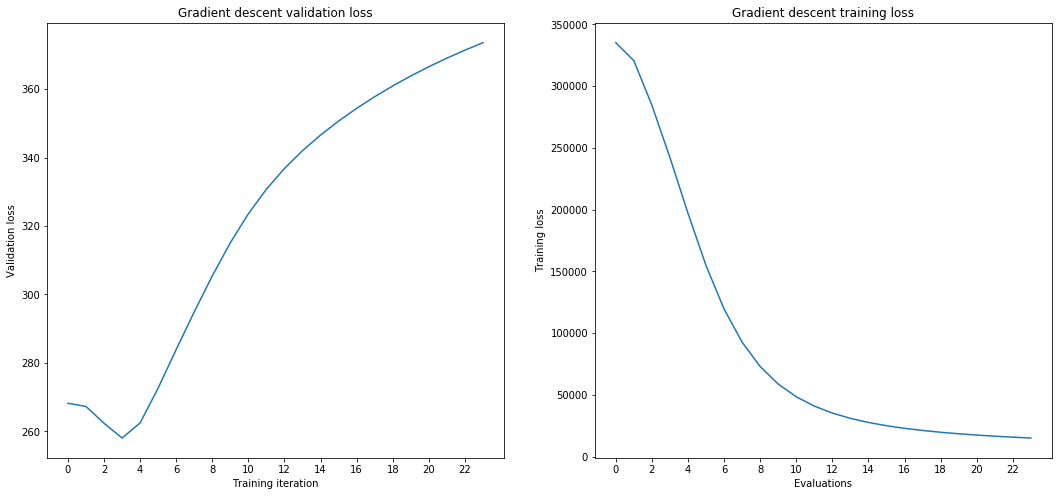

In [24]:
# First plot
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
x = np.arange(0, len(val_l_g_sweep), 1)
plt.plot(x, val_l_g_sweep)
plt.title(s='Gradient descent validation loss', loc='center')
plt.xlabel(s='Training iteration')
plt.ylabel(s='Validation loss')
plt.xticks(range(0,len(x), 2))

# second plot
plt.subplot(1, 2, 2)
plt.plot(x, tr_l_g_sweep)
plt.title(s='Gradient descent training loss', loc='center')
plt.xlabel(s='Evaluations')
plt.ylabel(s='Training loss')
plt.xticks(range(0,len(x), 2))
plt.show()


In [25]:
Q_g_st, P_g_st, val_l_g_st, tr_l_g_st, conv_g_st = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=30, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=1e-4, learning_rate=1e-6,
                                                                                   init='random', batch_size=1,
                                                                                   max_steps=20000, log_every=500, 
                                                                                   eval_every=50)

Iteration 0,  training loss: 16839253.551, validation loss: 12011.287, time per iteration: 0.425
Iteration 500,  training loss: 87854183328891230819975168.000, validation loss: 9511001856196.586, time per iteration: 0.022
Iteration 1000,  training loss: 138273726151475536192383079813198104231936.000, validation loss: 16945819180928526.000, time per iteration: 0.023
Iteration 1500,  training loss: 8680907724512816007801001828702148177341629602813371192019008573130554031685468179667479156234128453854116868141285959285178758301872012812294340344807424.000, validation loss: 2909287732661963424903725056.000, time per iteration: 0.022
Iteration 2000,  training loss: 1164032739840051225680512403207957294865020945565277152042631980053052594948068979474475021974548545211191209022999456592212814300901844195188274272626468954545586176.000, validation loss: 495386630959517020084092576727040.000, time per iteration: 0.022


C:\Users\Marc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in square
  """


Iteration 2500,  training loss: inf, validation loss: 165667194132381733566018003271607641656128194379983230384597879349261107200.000, time per iteration: 0.022
Iteration 3000,  training loss: inf, validation loss: 238584366561239888497658476212523209514371858481786060495739731599500826461599725056359932844426310520406016.000, time per iteration: 0.022
Iteration 3500,  training loss: inf, validation loss: 12243365650768719978277966088719767179384777229204762553465829730685284495472541798621215854485906529782948964983254054534182342313801416704.000, time per iteration: 0.022
Iteration 4000,  training loss: nan, validation loss: inf, time per iteration: 0.022


C:\Users\Marc\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in add


Iteration 4500,  training loss: nan, validation loss: inf, time per iteration: 0.022


C:\Users\Marc\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in add


Iteration 5000,  training loss: nan, validation loss: nan, time per iteration: 0.023
Iteration 5500,  training loss: nan, validation loss: nan, time per iteration: 0.021
Iteration 6000,  training loss: nan, validation loss: nan, time per iteration: 0.023
Iteration 6500,  training loss: nan, validation loss: nan, time per iteration: 0.021


C:\Users\Marc\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in multiply


Iteration 7000,  training loss: nan, validation loss: nan, time per iteration: 0.021
Iteration 7500,  training loss: nan, validation loss: nan, time per iteration: 0.021
Iteration 8000,  training loss: nan, validation loss: nan, time per iteration: 0.021


C:\Users\Marc\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: overflow encountered in multiply


Iteration 8500,  training loss: nan, validation loss: nan, time per iteration: 0.021
Iteration 9000,  training loss: nan, validation loss: nan, time per iteration: 0.022
Iteration 9500,  training loss: nan, validation loss: nan, time per iteration: 0.021
Iteration 10000,  training loss: nan, validation loss: nan, time per iteration: 0.021
Iteration 10500,  training loss: nan, validation loss: nan, time per iteration: 0.021
Iteration 11000,  training loss: nan, validation loss: nan, time per iteration: 0.021
Iteration 11500,  training loss: nan, validation loss: nan, time per iteration: 0.018
Iteration 12000,  training loss: nan, validation loss: nan, time per iteration: 0.020
Iteration 12500,  training loss: nan, validation loss: nan, time per iteration: 0.020
Iteration 13000,  training loss: nan, validation loss: nan, time per iteration: 0.020
Iteration 13500,  training loss: nan, validation loss: nan, time per iteration: 0.020
Iteration 14000,  training loss: nan, validation loss: na

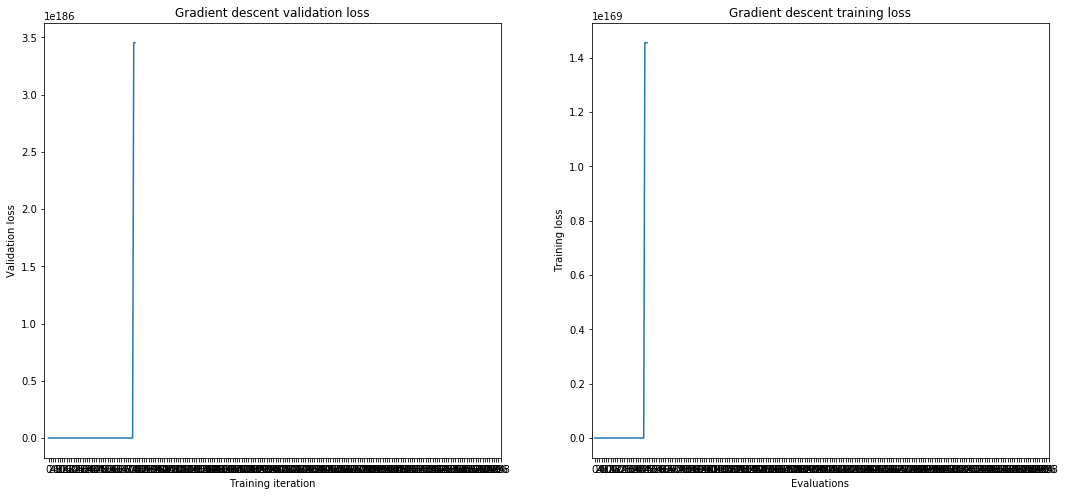

In [26]:
# First plot
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
x = np.arange(0, len(val_l_g_st), 1)
plt.plot(x, val_l_g_st)
plt.title(s='Gradient descent validation loss', loc='center')
plt.xlabel(s='Training iteration')
plt.ylabel(s='Validation loss')
plt.xticks(range(0,len(x), 2))

# second plot
plt.subplot(1, 2, 2)
plt.plot(x, tr_l_g_st)
plt.title(s='Gradient descent training loss', loc='center')
plt.xlabel(s='Evaluations')
plt.ylabel(s='Training loss')
plt.xticks(range(0,len(x), 2))
plt.show()


## Hyperparameter
Machine learning models are often heavily dependent on the hyperparameter settings, e.g. the learning rate. Here, we will try a simple random search to find good values of the latent factor dimension $k$, the batch size, learning rate, and regularization.  

Perform a hyperparameter search to find good values for the batch size, lambda, learning rate, and latent dimension. 

* For the batch size, we evaluate all values in [1, 32, 512, -1] (-1 corresponds to full-sweep gradient descent).
* For $\lambda$, we randomly sample three values in the interval [0, 1).
* For the learning rate, we evaluate all values in [1, 0.1, 0.01].
* For the latent dimension, we uniformly sample three values in the interval [5,30].

We perform an exhaustive search among all combinations of these values.


In [27]:
def parameter_search(M_train, val_idx, val_values):
    '''
    input
        M_train-> matrix to train
        
        val_idx -> indices for valdation
        
        val_values -> values for validation
    
    return
        
        best_conf -> best performing hyperparameter combination
    
    
    
    '''
    #basically the same as for Neural networks
    # Store away the nonzero indices of M before subtracting the row means.
    nonzero_indices = np.vstack((M_train.nonzero()[0], M_train.nonzero()[1])).T

    # Remove user means.
    M_shifted, user_means = shift_user_mean(M_train)

    # Apply the same shift to the validation and test data.
    val_values_shifted = val_values - user_means[val_idx[0]]
    test_values_shifted = test_values - user_means[test_idx[0]]
    
    
    batch_sizes = [1,32,512,-1]
    lam = np.random.rand(3)*1e-2
    lr = [1e-3, 1e-4, 1e-6]
    ld = np.random.randint(low=5, high=31, size=3)
    best_val_loss = -1
    best_conf = {}
    for bs in batch_sizes:
        for l in lam:
            for eta in lr:
                for dim in ld:
                    print("Training with configuration: batch size %i, lambda %f, eta %f, latent dimension %i"%(bs, l, eta, dim))
                    
                    ##Train latent_factor_gradient_descent
                    Q, P, val_loss, tr_loss, conv =  latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=dim, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=l, learning_rate=eta,
                                                                                   init='svd', batch_size=bs,
                                                                                   max_steps=10000, log_every=500, 
                                                                                   eval_every=20)
                    
                    val_loss_min = min(val_loss)
                    if best_val_loss == -1 or best_val_loss > val_loss_min:
                        best_val_loss = val_loss_min
                        best_conf = {'batch_size':bs, 'lambda':l, 'learning_rate':eta, 'latent_dimension':dim}
                        print("New best configuration with loss %f"%val_loss_min)
                    print("\n")
                        
        
    print("Best configuration is {}").format(best_conf)
    return best_conf

In [28]:
best_configuration = parameter_search(M_train, val_idx, val_values)

Training with configuration: batch size 1, lambda 0.007539, eta 0.001000, latent dimension 10
Iteration 0,  training loss: 336390.882, validation loss: 268.281, time per iteration: 0.349
Converged after 140 iterations, on average 0.041 seconds per iteration.
New best configuration with loss 267.721262


Training with configuration: batch size 1, lambda 0.007539, eta 0.001000, latent dimension 20
Iteration 0,  training loss: 335953.859, validation loss: 268.265, time per iteration: 0.401
Converged after 20 iterations, on average 0.048 seconds per iteration.
New best configuration with loss 267.075596


Training with configuration: batch size 1, lambda 0.007539, eta 0.001000, latent dimension 18
Iteration 0,  training loss: 4533545.323, validation loss: 267.152, time per iteration: 0.406
Iteration 500,  training loss: 16148472256736143263240266529879621632.000, validation loss: 633717.033, time per iteration: 0.031
Iteration 1000,  training loss: 30900245950744429717007374148378328196710

C:\Users\Marc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in square
  """


Iteration 2000,  training loss: inf, validation loss: 2923858541198996796932360022788574498351019297153708819054507857863713488896.000, time per iteration: 0.030
Iteration 2500,  training loss: inf, validation loss: 13752359974573535138208420834239894191182477227391378876819307464289873225839233804968458353754767360.000, time per iteration: 0.030
Iteration 3000,  training loss: inf, validation loss: inf, time per iteration: 0.029


C:\Users\Marc\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in add


Iteration 3500,  training loss: nan, validation loss: inf, time per iteration: 0.031
Iteration 4000,  training loss: nan, validation loss: nan, time per iteration: 0.030
Iteration 4500,  training loss: nan, validation loss: nan, time per iteration: 0.030


C:\Users\Marc\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in add


Iteration 5000,  training loss: nan, validation loss: nan, time per iteration: 0.031


C:\Users\Marc\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in multiply


Iteration 5500,  training loss: nan, validation loss: nan, time per iteration: 0.029
Iteration 6000,  training loss: nan, validation loss: nan, time per iteration: 0.030
Iteration 6500,  training loss: nan, validation loss: nan, time per iteration: 0.030
Iteration 7000,  training loss: nan, validation loss: nan, time per iteration: 0.027


C:\Users\Marc\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: overflow encountered in multiply


Iteration 7500,  training loss: nan, validation loss: nan, time per iteration: 0.031
Iteration 8000,  training loss: nan, validation loss: nan, time per iteration: 0.030


C:\Users\Marc\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Iteration 8500,  training loss: nan, validation loss: nan, time per iteration: 0.031
Iteration 9000,  training loss: nan, validation loss: nan, time per iteration: 0.030
Iteration 9500,  training loss: nan, validation loss: nan, time per iteration: 0.030
Did not converge in 10000 iterations, on average 0.031 seconds per iteration.


Training with configuration: batch size 1, lambda 0.007539, eta 0.000100, latent dimension 10
Iteration 0,  training loss: 336390.554, validation loss: 268.291, time per iteration: 0.397
Iteration 500,  training loss: 56635430255875.047, validation loss: 272.979, time per iteration: 0.027
Converged after 100 iterations, on average 0.042 seconds per iteration.


Training with configuration: batch size 1, lambda 0.007539, eta 0.000100, latent dimension 20
Iteration 0,  training loss: 335823.598, validation loss: 268.265, time per iteration: 0.404
Iteration 500,  training loss: 12363608345563521890648064.000, validation loss: 270.035, time per iteration: 0.031

Iteration 1000,  training loss: 685884196941018398403691945013734346116935345258717584390313520586033505293102311807201274677526305525263102058270036816149679909658028116945535772246671360.000, validation loss: 428655677994254089791030899607863296.000, time per iteration: 0.029
Iteration 1500,  training loss: 5404962579512551837501163631003451057411550175130103377105659702692361448653271690208481453039281174714571437127624481136557764333259886875821392512781553862812838988500100199712884293771820973934796425468442783237675669870379140120576.000, validation loss: 1544807817119973680688566014179758100426780573696.000, time per iteration: 0.032
Iteration 2000,  training loss: inf, validation loss: 1560800384307547765230215271012800080574566345620994975902813417743375929032254218806293256442163268964585522344413234435457024.000, time per iteration: 0.030
Iteration 2500,  training loss: nan, validation loss: inf, time per iteration: 0.029
Iteration 3000,  training loss: nan, validation loss

KeyboardInterrupt: 

to find the best hyperparameter I suggest a cluster, as it ran for 1h before I interrupted it

In [ ]:
bbs = best_configuration['batch_size']
blmbd = best_configuration['lambda']
blr = best_configuration['learning_rate']
bld = best_configuration['latent_dimension']
print("Best batch size: %i\nBest lambda: %f\nBest learning rate: %f\nBest latent dimension: %i"%(bbs, blmbd, blr, bld))

## Comparison of gradient descent and alternating optimization

* Whats the advantage of sgd  and the difference between fbgd and mbgd?
  - Batch gradient descent computes the gradient using the whole dataset. This is great for convex, or relatively smooth error manifolds. In this case, we move somewhat directly towards an optimum solution, either local or global. Stochastic gradient descent (SGD) computes the gradient using a single sample. Most applications of SGD actually use a minibatch of several samples. SGD works well for error manifolds that have lots of local maxima/minima. In this case, the somewhat noisier gradient calculated using the reduced number of samples tends to jerk the model out of local minima into a region that hopefully is more optimal. Single samples are really noisy, while minibatches tend to average a little of the noise out. Thus, the amount of jerk is reduced when using minibatches. A good balance is struck when the minibatch size is small enough to avoid some of the poor local minima, but large enough that it doesn't avoid the global minima or better-performing local minima.

* We compare the root mean square errors (RMSE) for the training, validation, and test sets different settings of $k$ for both alternating optimization and gradient descent.
  - While varying the value for k, we can observe that a big k improves the loss on the training set but results in overfitting because bigger matrices Q and P can capture the data while training better. For Gradient Descent we found the best value for k to be around 25, for Alternating Optimization 100 produced the best results.

* We compare the test RMSE for the alternating optimization model and the gradient descent model. 

  - We found that the RMSE for gradient descent is lower than the one for alternating optimization. We also found from looking at the plots that higher ratings are predicted more accurately. Thats probably that the stochastic gradient descent do not end up in a local minimum trough the noise enabled because we dont use all the data and a learning rate.

In [30]:
def rmse(P,Q,M,non_zero_idx):
    return np.sqrt(np.mean(np.array(M[non_zero_idx[:,0], non_zero_idx[:,1]]-(Q.dot(P))[non_zero_idx[:,0], non_zero_idx[:,1]])**2))

def rmse_val(val_values, val_idx, P, Q):
    return np.sqrt(np.mean(np.array(val_values-(Q.dot(P))[val_idx[0], val_idx[1]])**2))

In [31]:
# Finding the best k for gradient descent
k_values = [25, 50, 100, 150]
best_val_loss = -1
best_GD_conf = {}
for k in k_values:
    print("Training gradient descent with k = %i"%(k))
                    
    ##Train latent_factor_gradient_descent
    Q, P, val_loss, tr_loss, conv =  latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                    k=k, val_idx=val_idx,
                                                                    val_values=val_values_shifted, 
                                                                    reg_lambda=1e-2, learning_rate=1e-3,
                                                                    init='svd', batch_size=-1,
                                                                    max_steps=5000, log_every=1000, 
                                                                    eval_every=20)
                    
    val_loss_min = min(val_loss)
    if best_val_loss == -1 or best_val_loss > val_loss_min:
        best_val_loss = val_loss_min
        best_GD_conf = {'k':k, 'Q':Q, 'P':P}
        print("New best configuration with loss %f"%val_loss_min)
    print("\n")

Training gradient descent with k = 25
Iteration 0,  training loss: 335368.179, validation loss: 268.238, time per iteration: 0.577
Converged after 60 iterations, on average 0.276 seconds per iteration.
New best configuration with loss 259.824325


Training gradient descent with k = 50
Iteration 0,  training loss: 334006.007, validation loss: 268.215, time per iteration: 0.668
Converged after 60 iterations, on average 0.307 seconds per iteration.


Training gradient descent with k = 100
Iteration 0,  training loss: 331564.106, validation loss: 268.254, time per iteration: 0.818
Converged after 60 iterations, on average 0.352 seconds per iteration.


Training gradient descent with k = 150
Iteration 0,  training loss: 329367.886, validation loss: 268.280, time per iteration: 1.056
Converged after 40 iterations, on average 0.409 seconds per iteration.




In [32]:
# Print the error of the best GD configuration
Q_GD, P_GD = best_GD_conf['Q'], best_GD_conf['P']
train_err = rmse(P_GD, Q_GD, M_shifted, nonzero_indices)
val_err = rmse_val(val_values_shifted, val_idx, P_GD, Q_GD)
test_err = rmse_val(test_values_shifted, test_idx, P_GD, Q_GD)
print("Training RMSE of best gradient descent model: %f"%train_err)
print("Validation RMSE of best gradient descent model: %f"%val_err)
print("Test RMSE of best gradient descent model: %f"%test_err)

Training RMSE of best gradient descent model: 0.937262
Validation RMSE of best gradient descent model: 1.139790
Test RMSE of best gradient descent model: 1.086432


In [33]:
# Finding the best k for alternating optimization
k_values = [25, 50, 100, 150]
best_val_loss = -1
best_AO_conf = {}
for k in k_values:
    print("Training alternating optimization with k = %i"%(k))
                    
    ##Train latent_factor_gradient_descent
    Q, P, val_loss, tr_loss, conv  = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                            k=k, val_idx=val_idx,
                                                                            val_values=val_values_shifted, 
                                                                            reg_lambda=1, init='random',
                                                                            max_steps=100, patience=10)
                    
    val_loss_min = min(val_loss)
    if best_val_loss == -1 or best_val_loss > val_loss_min:
        best_val_loss = val_loss_min
        best_AO_conf = {'k':k, 'Q':Q, 'P':P}
        print("New best configuration with loss %f"%val_loss_min)
    print("\n")

Training alternating optimization with k = 25
Iteration 0,  training loss: 125260.792, validation loss: 331.192
Iteration 1,  training loss: 76328.114, validation loss: 375.364
Iteration 2,  training loss: 60256.452, validation loss: 386.986
Iteration 3,  training loss: 52038.227, validation loss: 397.562
Iteration 4,  training loss: 47003.619, validation loss: 407.637
Iteration 5,  training loss: 43606.925, validation loss: 414.838
Iteration 6,  training loss: 41150.426, validation loss: 419.601
Iteration 7,  training loss: 39281.411, validation loss: 424.368
Iteration 8,  training loss: 37802.098, validation loss: 430.753
Iteration 9,  training loss: 36593.278, validation loss: 438.534
Iteration 10,  training loss: 35583.760, validation loss: 447.000
Converged after 2 iterations, on average 22.60 seconds per iteration.
New best configuration with loss 331.191522


Training alternating optimization with k = 50
Iteration 0,  training loss: 67216.829, validation loss: 351.832
Iteration 

In [34]:
# Print the error of the best AO configuration
Q_AO, P_AO = best_AO_conf['Q'], best_AO_conf['P']
train_err = rmse(P_AO, Q_AO, M_shifted, nonzero_indices)
val_err = rmse_val(val_values_shifted, val_idx, P_AO, Q_AO)
test_err = rmse_val(test_values_shifted, test_idx, P_AO, Q_AO)
print("Training RMSE of best alternating optimization model: %f"%train_err)
print("Validation RMSE of best alternating optimization model: %f"%val_err)
print("Test RMSE of best alternating optimization model: %f"%test_err)

Training RMSE of best alternating optimization model: 0.143585
Validation RMSE of best alternating optimization model: 1.244094
Test RMSE of best alternating optimization model: 1.247788


## Plot pred. vs ground truth

In the following scatter plots we can see, how the different ratings get predicted compared to different datasets. 

The predicted ratings are in range 1-6 as of the standard deviance cutoff.

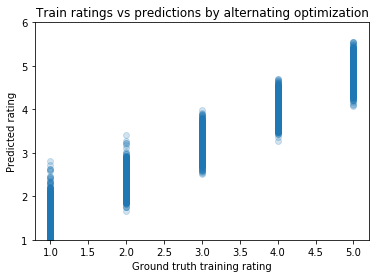

In [35]:
# user means have to be added to retrieve original values
M_pred_AO = Q_AO.dot(P_AO) + np.matrix(user_means).T
plt.scatter(np.asarray(M[nonzero_indices[:,0], nonzero_indices[:,1]]).flatten(), np.asarray(M_pred_AO[nonzero_indices[:,0], nonzero_indices[:,1]]).flatten(), alpha=0.2)
plt.xlabel(s="Ground truth training rating")
plt.ylabel(s="Predicted rating")
plt.title("Train ratings vs predictions by alternating optimization", loc='center')
plt.ylim([1,6])
plt.show()

In this plot we see that the train ratings match quit well with a standard deviance of around 1 to the predicted ratings of the alternating optimization algorithm.

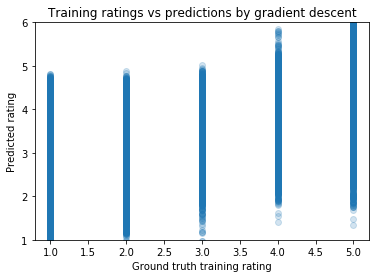

In [36]:
M_pred_GD = Q_GD.dot(P_GD) + np.matrix(user_means).T 
plt.scatter(np.asarray(M[nonzero_indices[:,0], nonzero_indices[:,1]]).flatten(), np.asarray(M_pred_GD[nonzero_indices[:,0], nonzero_indices[:,1]]).flatten(), alpha=0.2)
plt.xlabel(s="Ground truth training rating")
plt.ylabel(s="Predicted rating")
plt.title("Training ratings vs predictions by gradient descent", loc='center')
plt.ylim([1,6])
plt.show()

When we plot the gradient descent against the training data we have a larger variance.

So when we compare the training results of both methods, it seams that the alternating optimization method has better results on the training data then the stochastic gradient descent method.

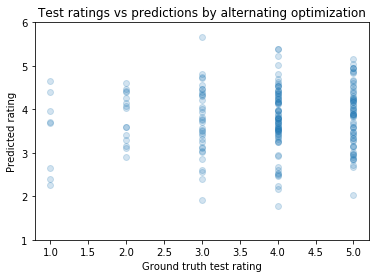

In [37]:
M_pred_AO = Q_AO.dot(P_AO) + np.matrix(user_means).T 
plt.scatter(test_values, np.asarray(M_pred_AO[test_idx]).flatten(), alpha=0.2)
plt.xlabel(s="Ground truth test rating")
plt.ylabel(s="Predicted rating")
plt.title("Test ratings vs predictions by alternating optimization", loc='center')
plt.ylim([1,6])
plt.show()

Test ratings vs predictions of the alternating optimization leads to good results for high values, but bad for low values (probably because there is more good rated restaurants then bad rated (in the test set, as well as in the training set))

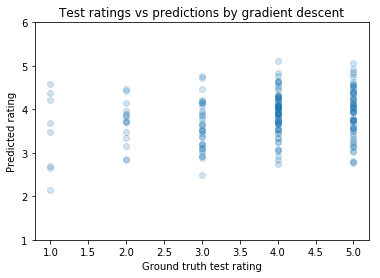

In [38]:
M_pred_GD = Q_GD.dot(P_GD) + np.matrix(user_means).T
plt.scatter(test_values, np.asarray(M_pred_GD[test_idx]).flatten(), alpha=0.2)
plt.xlabel(s="Ground truth test rating")
plt.ylabel(s="Predicted rating")
plt.title("Test ratings vs predictions by gradient descent", loc='center')
plt.ylim([1,6])
plt.show()

in the test vs predictions of the sgd method our results are far better, but all quit close to the mean.

In general its hard to distinguish which method is better to find the right matrices $P$ and $Q$, but in the literature the SGD method is recommended. Maybe if we apply the method on the initial netflix dataset, we would have get better results.

# Documentation File


## Advanced Data Analytics Spring 2018                     

## Recommendation Algorithms


Marc Schmid 	                      - 13349752

Jorge Villanueva Salamero  - 13350309

04/10/2018


### Introduction

Nowadays, recommender systems are present in all kind of applications, whether they are mobile or web, such as Amazon, Spotify or Netflix. For example, when buying a product online, recommendations suggest to the user the product that may be of their greatest interest according to specific preferences.

The main idea is to look for patterns of activities between different users in order to predict preference of a user with an item.  An example in the food industry could be: If most of the people who buy milk also buy coffee, a new person who has already bought coffee it's very likely that will also buy milk. This information could be used to place the products very close in the shelves to increase the sales and the profit. Another case is the unexpected correlation between beers and diapers [https://tdwi.org/articles/2016/11/15/beer-and-diapers-impossible-correlation.aspx].

Throughout this paper, we are going to propose a few algorithms with the simple goal of making good recommendations on restaurants the user has not visited yet, based on the yelp dataset. It is important to highlight its high relevance in the field of machine learning and Big Data due to its substantial economical impact.


### Problem Formulation

The main idea for recommender systems is trying to predict, with the highest accuracy as possible the future ratings that a user will make on items that have not yet been rated. These rating will be represented in our utility matrix, where the blank cells represent unknown information. 

<img src="files/images/image6.jpg">
This matrix is composed by rows that correspond to users and columns to movies. Each entry in the matrix represent to the rating of an specific user towards a movie (the higher the value, the more the user likes the movie), It is important to highlight, that most of these entries are empty, meaning that most users have not seen most of the movies, which makes a lot of sense.

In our case we had a matrix which is composed of  x users and y restaurants, where different users reviewed different restaurants and gave them a specific rating between 1 and 5.
The matrix itself is very sparse because not all users could review/visit all restaurants.


### First Approach

For making accurate predictions possible, it is necessary to split the original dataset into three different sets: Training, Validation and Test Set. The training data will be used to build our model, the test set will be used once the training has been finished to assess the quality of the model built ( in an informal way the validation and test dataset will be obtained by “hiding” a number of entries in our utility matrix ).

In order to analyze the goodness of our model, we will try to minimize the RMSE or root-mean-square-error, a measure of the differences between the values predicted and the ones observed ( where x represent the user, i represent the item, and xi represent the rating of the user x to the item i ). 

$$RMSE = \frac{1}{|R|}\sqrt{\sum_{(x,i) \in R}({r^g}_{xi}-r_{xi})^2}$$

where $r^g$ is the observed value and $r$ is the predicted one.


### Latent Factor Model Algorithm

The main idea for this algorithm is to think of recommendations as an optimization problem, where the objective is to make the best rating predictions ( trying to identify the preference of a user towards an item), .

The way we will approach the construction of the model is called matrix factorization, which is highly related with the SVD (singular value decomposition reduction), these details will be explained afterwards.

The following steps are necessary to achieve this. First, it's essential to factorize our original matrix as a product of two Matrix where very user and item gets mapped it into a k-dimensional space, ( in the example below, k equals 3 ).







The objective will be to find a lower dimensional representation where 
every user and item are represented as data points in the space, the closer they are, the more related.

<img src="files/images/image1.png">
Factorized Matrix Model  of a Matrix R

To estimate a hidden rating in the initial utility matrix, for example, take the data in row 3 and column 6. It will be necessary to make the dot product between the vectors of the third row of the matrix Q and the sixth column of the matrix P. The value obtained will be mapped into the two-dimensional space compounded of users and items. As a result, it will be possible to estimate the relation with different users and items depending on the proximity in the space.

$$R = QP^T$$

This approach as we previously remarked, is very close related to the Singular Value Decomposition. In which the original matrix is decomposed into three matrices, U left singular vectors, V Right singular vecs and the diagonal  matrix $\Sigma$ which are the eigenvalues values.  Where $Q = U \Sigma$   and $P=V$. 

However as most of the entries in the utility matrix are empty, and SVD will interprete these entries as 0 values (lower rating), it was necessary to solve this as an optimization problem, where our goal was to find the matrices P and Q so that we just use the given rating values, and don't use the empty 0 of the rating matrix, thus we try to minimize 
$$ \min_{P,Q} \sum_{i,x\in R} (r_{x,i}-q_xp_i^T)^2$$

Therefore we use Alternating Optimization as an approach (Alternating optimization is a Standard method for latent factor models. I.e.:it also gets used to solve Gaussian mixture models, where we first update the distributions and then the latent variables):

The steps are : 
1. initialize $P,Q$ and $t=0$
2. $P^{t+1} = argmin_P f(P,Q^t)$
3. $Q^{t+1} = argmin_P f(P^{t+1},Q)$
4. $t=t+1$
5. goto 2 until values converge

Since P and Q are fixed respectively, the problem reduces to an ordinary least sqaure regression problem which has a closed form solution.

Thus the ordinary least sqaured solution for each iteration becomes
the P-update is:
$$ p_i^T = \left(\frac{1}{|R_{*,i}|}\sum_{x \in R_{*,i}} q_x^Tq_x\right)^{-1} \frac{1}{|R_{*,i}|}\sum_{x \in R_{*,i}} q_x^T r_{xi} $$
The Q-update is:
$$ q_x^T = \left(\frac{1}{|R_{i,*}|}\sum_{x \in R_{i,*}} p_x^Tp_x \right)^{-1} \frac{1}{|R_{i,*}|}\sum_{x \in R_{i,*}} p_x^T r_{ix} $$




### Gradient Descent Optimization Algorithm

Another approach to find the minimum of the losss function is called Gradient descent.
$$
\mathcal{L} = \min_{P, Q} \sum_{(x, i) \in W} (r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2 + \lambda_1\sum_x{\left\lVert \mathbf{p}_x  \right\rVert}^2 + \lambda_2\sum_i {\left\lVert\mathbf{q}_i  \right\rVert}^2
$$
where $W$ is the set of $(x, i)$ pairs for which $r_{xi}$ is known. Here we have also introduced two regularization terms to help us with overfitting $*$ where $\lambda_1$ and $\lambda_2$ are hyper-parameters that control the strength of the regularization.

This method first evaluate the derivative of the function to then move in the reverse direction of the gradient, these steps are repeated until it converges into a local or global minimum. 
The derivatives of the loss function are: 

$$
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{p}_x} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{q}_i\;, ~~~
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{q}_i} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{p}_x 
$$

$$
\frac{\partial(\lambda_1{\left\lVert \mathbf{p}_x \right\rVert}^2)}{\partial \mathbf{p}_x} = 2 \lambda_1 \mathbf{p_x} \;, ~~~
\frac{\partial(\lambda_2{\left\lVert \mathbf{q}_i \right\rVert}^2)}{\partial \mathbf{q}_i} = 2 \lambda_2 \mathbf{q_i}
$$

the algorithm is then :
1. initialize e $P,Q$ and $t=0$
2. compute the gradients of $\mathcal{L}$ with respect to $P$ and $Q$.
3. update $P$ and $Q$ with $P = P - \alpha \nabla P$ and  $Q = Q - \alpha \nabla Q$
4. goto 2 until convergence or maximum of iterations


$*$Overfitting results in the number of factors k, as higher this number is, the model parameter increases and thus the model is gaining too much freedom and therefore overfitting to the training data. To solve this we modified the optimization function by adding the regularization parameter lambda.

By doing this we got a rich model where the are sufficient data, and a simple one when the data is sparse. When lambda tends to 0, regularization therms vanish, and we overfit the data (which is wanted for checking if the model converges at least).

We evaluate the model with the training and Validation set, to see when its overfitting and save the parameters for the smallest error in the validation set.


### Hyperparameters 

In order to find the best parameters values for our latent factor gradient descent algorithm, that will increase both the computational speed of the model and the accuracy of the predictions, it is necessary to perform a hyperparameter search throughout the most influential parameters in the training of the model, in our case batch size, lambda, learning rate, and latent dimension.

The search was performed with a whole set of values; these can be found in the source code. It’s an exhaustive search, therefore we recommend to minimize the dataset for the search and parallelize it for clusters to increase computing time.



### Further Research

As a future work for this project, is the possibility of implementing a different algorithm based on local neighbourhood properties, to assess if the RMSE with the test dataset improves, and therefore our model too. For example, one of this algorithms could be collaborative filtering,

The main idea for this method is making recommendations on specific items based on previously ratings of the same user on similar items ( commonly known as item based collaborative filtering ) .


### Conclusion 

This project has shown us what a real-life recommendation problem could look like, where all the techniques learned during the lectures and through previous courses were put into practice to deal with the issues that have been appearing such as assessing which algorithms or techniques are more appropriate for making the most accurate predictions. The experience gained through this assignment will undoubtedly be of great help for further data analytics problems.


### References

[1] Lecture 54 — Latent Factor Models | Stanford University
https://www.youtube.com/watch?v=4-f77HjB_CI&t=205s

[2]  Lecture 55 — Latent Factor Recommender System | Stanford University		             https://www.youtube.com/watch?v=E8aMcwmqsTg 

[3] Lecture 56 — Finding the Latent Factors | Stanford University
https://www.youtube.com/watch?v=GGWBMg0i9d4&t=11s

[3] Recommender Systems: Latent factor Models
http://snap.stanford.edu/class/cs246-2015/slides/08-recsys2.pdf
  
[4] Root-mean-square deviation
https://en.wikipedia.org/wiki/Root-mean-square_deviation

[5] Hyperparameter tuning I
https://www.coursera.org/lecture/competitive-data-science/hyperparameter-tuning-i-giBKx

[6] Yehuda Koren, “Matrix Factorization Techniques for Recommender
Systems,” IEEE Computer Society, IEEE 0018-9162/09, pp. 42- 49, 2009
https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf

[7] Trevor Hastie, Robert Tibshirani, Jerome Friedman: The Elements of Statistical
Learning: Data Mining, Inference, and Prediction, Springer, 2013; Chapter 3
https://web.stanford.edu/~hastie/Papers/ESLII.pdf

[8] Hastie, Trevor, Robert Tibshirani, and Martin Wainwright. Statistical learning
with sparsity: the lasso and generalizations. CRC Press, 2015.
https://web.stanford.edu/~hastie/StatLearnSparsity_files/SLS_corrected_1.4.16.pdf
